<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data transformation](#data_transformation)
3. [Data exploration](#data_exploration)
4. [Data preparation](#data_preparation)
5. [Data examinatino](#data_examination)
5. [Benchmark model](#benchmark_model)<br>
6. [Model training](#model_training)<br>
7. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [22]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import STL
from time import time



# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
print(os.getcwd())
# return datatime
def parser(s):
    return datetime.strptime(s, '%Y-%m')


airpassenger = pd.read_csv('AirPassengers.csv', parse_dates= [0], index_col= 0, date_parser= parser, header= [0])


d:\Main\Data-Analysis\AirPassengerForecast


C:\Users\bakbarza\AppData\Local\Temp\ipykernel_11148\1494554016.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  airpassenger = pd.read_csv('AirPassengers.csv', parse_dates= [0], index_col= 0, date_parser= parser, header= [0])


# 2. Data transformation <a id='data_transformation'></a>
[Back to top](#table_of_contents)

In [3]:


airpassenger = airpassenger.asfreq(pd.infer_freq(airpassenger.index))
airpassenger.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

# 3. Data exploration <a id='data_exploration'></a>

[Back to top](#table_of_contents)

In [4]:
print(airpassenger.isna().sum())
columnName = airpassenger.columns
print(columnName)
airpassenger.describe()

# if there is nan 

#Passengers    0
dtype: int64
Index(['#Passengers'], dtype='object')


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [5]:
airpassenger = airpassenger.rename(columns = {'#Passengers':'Passengers'})
start_time = datetime(1949, 1, 1)
end_time = datetime(1956, 1, 1)
lim_airpassenger = airpassenger[start_time:end_time]

# 4. Data examination <a id='data_examination'></a>
[Back to top](#table_of_contents)

C:\Users\bakbarza\AppData\Local\Temp\ipykernel_11148\3874105700.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)


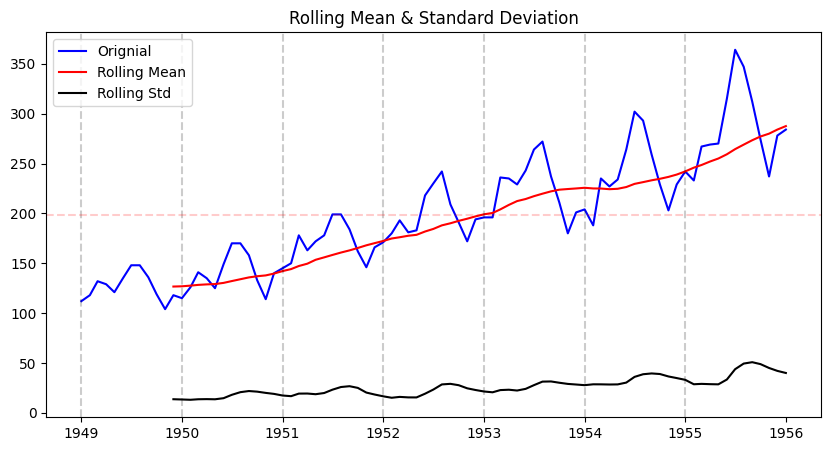

Results of Dickey-Fuller Test:
Test Statistic                  0.919455
p-value                         0.993339
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [6]:
def test_stationary(timeSeries):
    # the Original
    plt.figure(figsize=(10, 5))
    origin = plt.plot(timeSeries, color = 'blue', label = 'Orignial')


    # Cosntant mean
    MA = timeSeries.rolling(window =12).mean()
    mean = plt.plot(MA, color = 'red', label = 'Rolling Mean')

    # Constant var
    MSTD = timeSeries.rolling(window = 12).std()
    std = plt.plot(MSTD, color = 'black', label = 'Rolling Std')


    # indicate timestamps
    for year in range(pd.to_datetime(timeSeries.index.min()).year, pd.to_datetime(timeSeries.index.max()).year ):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

    plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


    # perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeSeries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationary(lim_airpassenger)



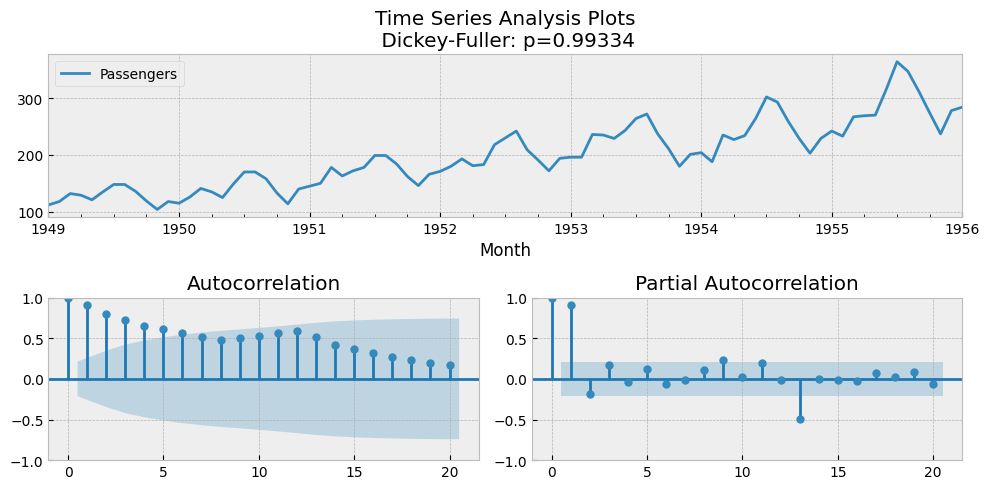

In [12]:
def displayTimeSeries(timeSeries, lags=None, figsize=(10, 5), style='bmh'):    
    
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan= 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        timeSeries.plot(ax = ts_ax)
        p_value = adfuller(timeSeries)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(timeSeries, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(timeSeries, lags=lags, ax=pacf_ax)
        plt.tight_layout()


displayTimeSeries(timeSeries= lim_airpassenger)


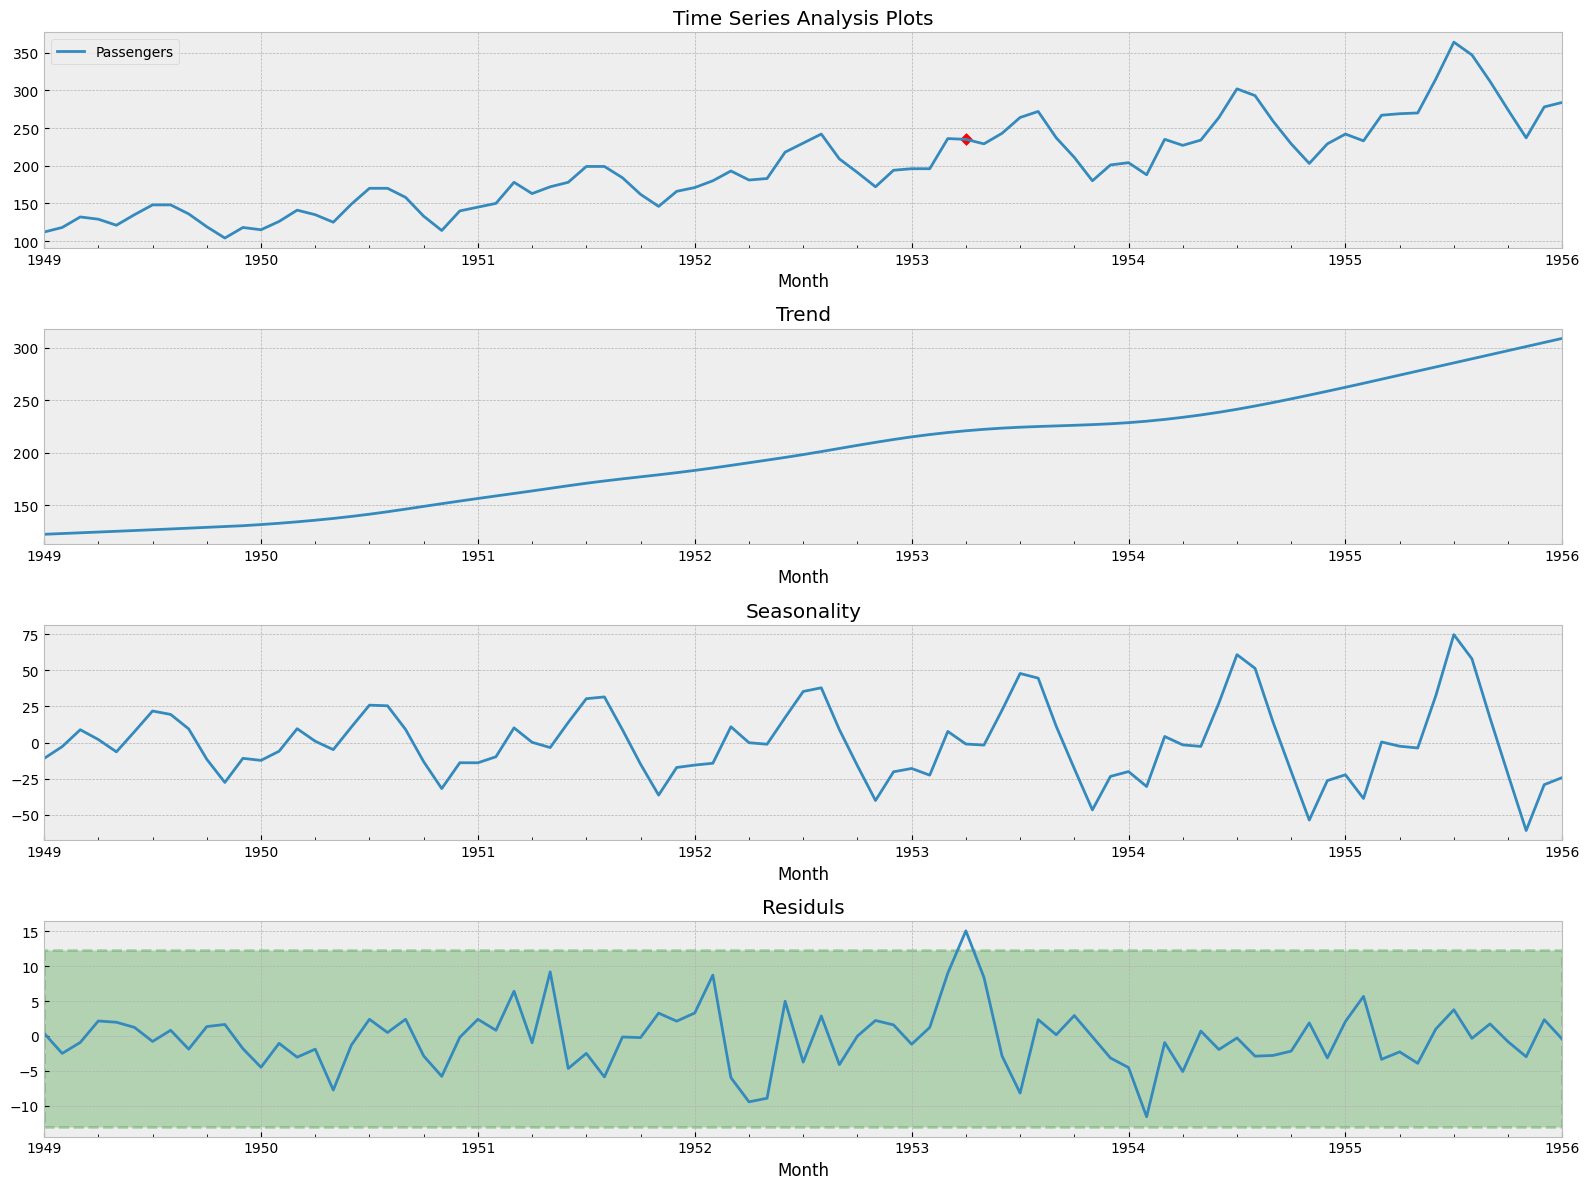

In [8]:
# finding anamually 

def displayDecomposed(timeSeries, figsize=(16, 12), style='bmh'):
    seasonal_trend_dec =  STL(timeSeries)
    stlResult = seasonal_trend_dec.fit()
    seasonal, trend, resid = stlResult.seasonal, stlResult.trend, stlResult.resid

    resid_mu = resid.mean()
    resid_dev = resid.std()
    lower = resid_mu - 2.96*resid_dev
    upper = resid_mu + 2.96*resid_dev
    
    anomalies = timeSeries[(resid < lower) | (resid > upper)]

    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        tr_ax = plt.subplot2grid(layout, (1, 0))
        ss_ax = plt.subplot2grid(layout, (2, 0))
        rs_ax = plt.subplot2grid(layout, (3, 0))

        timeSeries.plot(ax = ts_ax)
        if len(anomalies) > 0:
            ts_ax.scatter(anomalies.index, timeSeries[timeSeries.columns[0]][anomalies.index], color='r', marker='D')
        ts_ax.set_title('Time Series Analysis Plots')    
        


        trend.plot(ax = tr_ax)
        tr_ax.set_title('Trend')
        seasonal.plot(ax = ss_ax)
        ss_ax.set_title('Seasonality')
        resid.plot(ax = rs_ax)
        rs_ax.fill_between(timeSeries.index ,lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
        
        rs_ax.set_title('Residuls')
        plt.tight_layout()


displayDecomposed(timeSeries= lim_airpassenger)


# 5. Data transformation <a id='data_transformation'></a>
[Back to top](#table_of_contents)

C:\Users\bakbarza\AppData\Local\Temp\ipykernel_11148\2000015739.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equalSize_month_avg =  transformed_airpassenger.index.map(lambda d: month_avgs.loc[d.month][0])
C:\Users\bakbarza\AppData\Local\Temp\ipykernel_11148\3874105700.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)


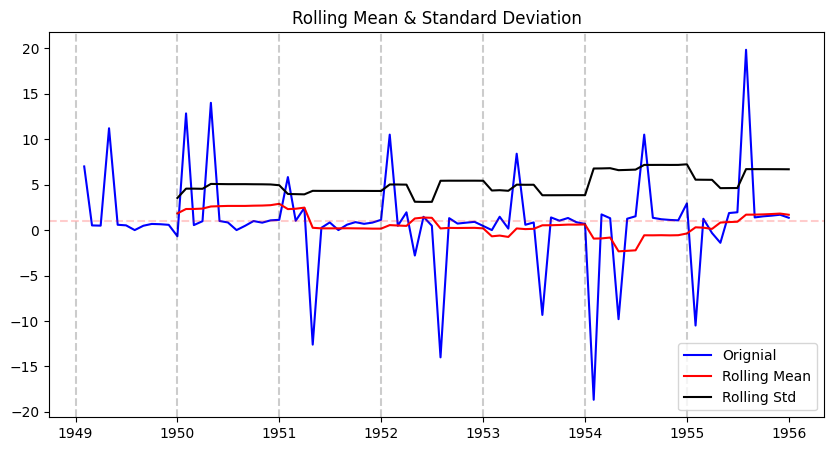

Results of Dickey-Fuller Test:
Test Statistic                -9.329162e+00
p-value                        9.430593e-16
#Lags Used                     0.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


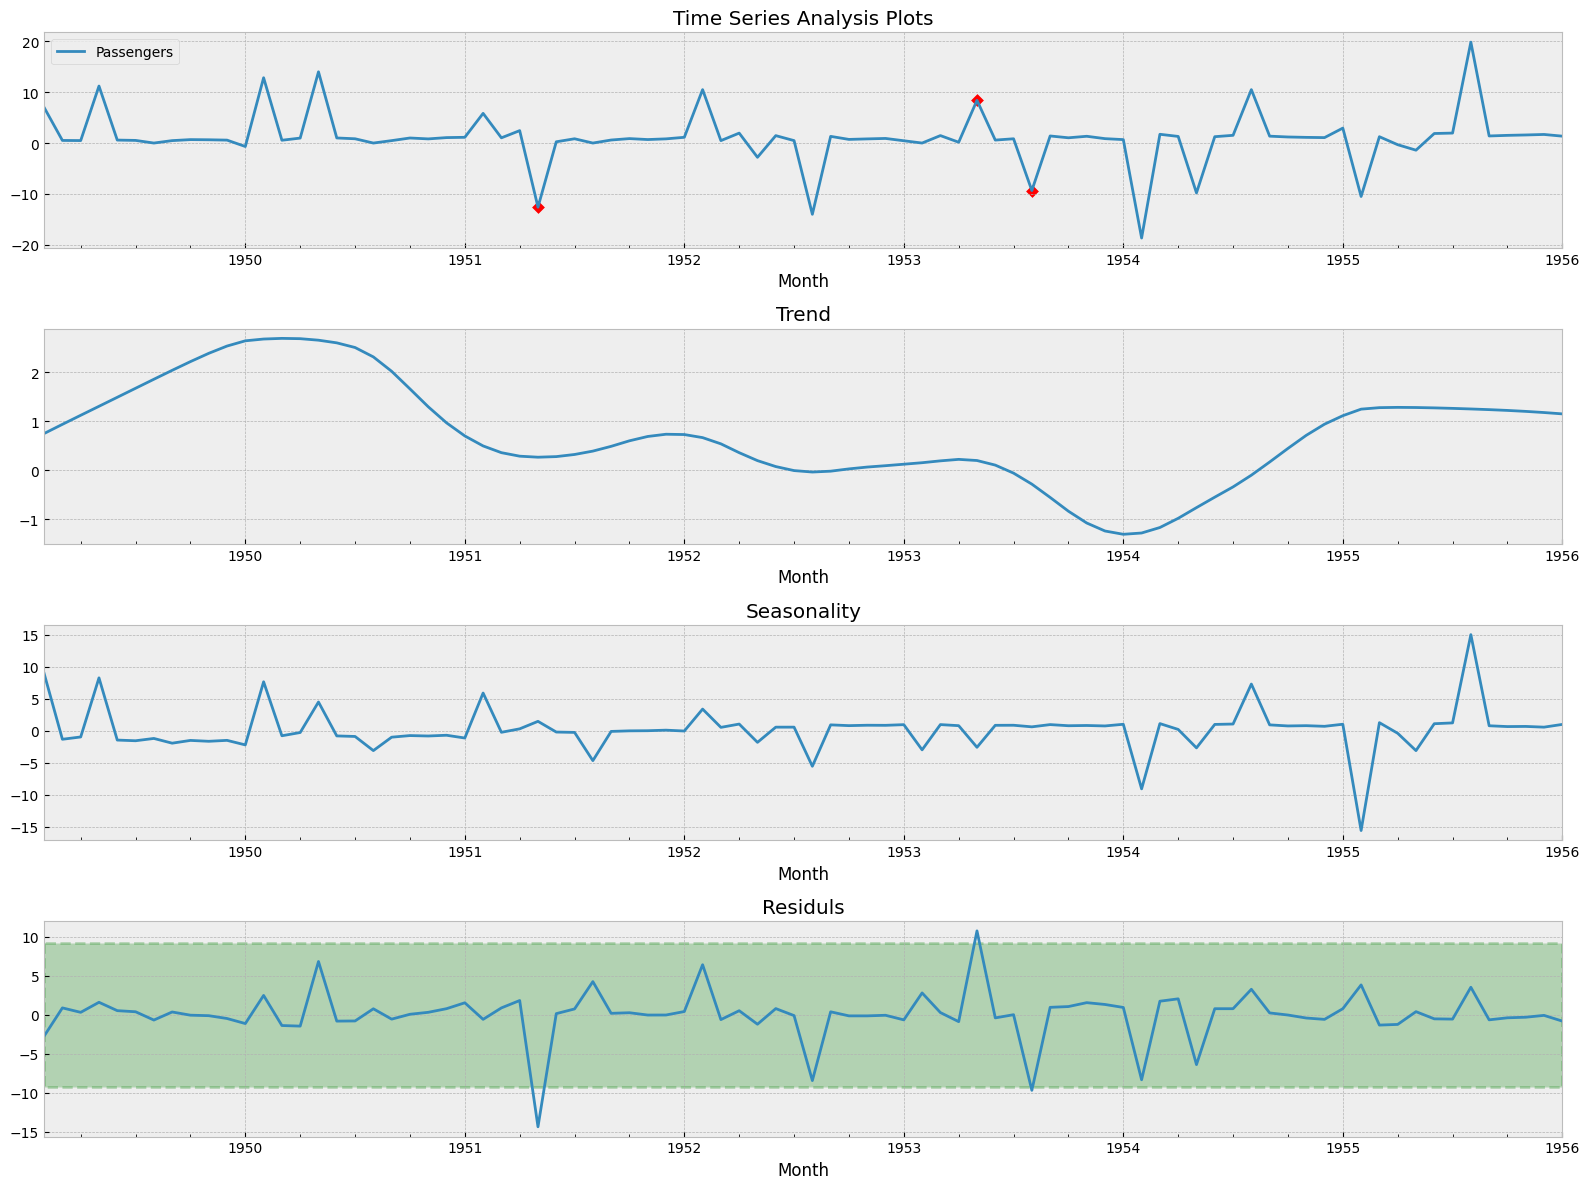

In [98]:
# Removing trends, first differnece? second diffrences?
transformed_airpassenger = lim_airpassenger.diff()
transformed_airpassenger = transformed_airpassenger.dropna()


# Removing seasonality by deviding to the monthly avarage 
month_avgs = transformed_airpassenger.groupby(transformed_airpassenger.index.month).mean()
equalSize_month_avg =  transformed_airpassenger.index.map(lambda d: month_avgs.loc[d.month][0])
#print(equalSize_month_avg)
# change the index
indexed_equalSize_month_avg = pd.DataFrame( {str(transformed_airpassenger.columns[0]): equalSize_month_avg}, index= transformed_airpassenger.index)

transformed_airpassenger = transformed_airpassenger / indexed_equalSize_month_avg

test_stationary(timeSeries= transformed_airpassenger)
#displayDecomposed(timeSeries= i_airpassenger)

displayDecomposed(timeSeries= transformed_airpassenger)
    

# 6. Model fiting  <a id='model_fiting'></a>
[Back to top](#table_of_contents)

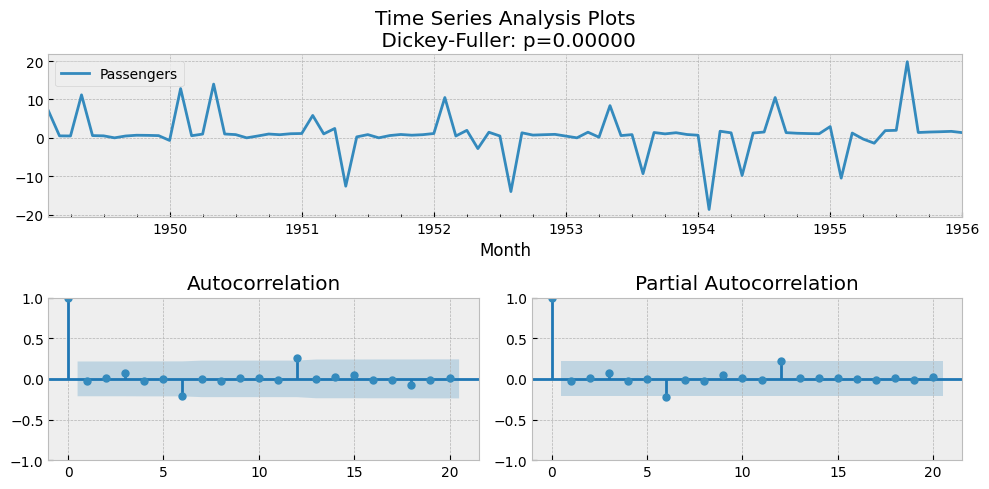

In [99]:

displayTimeSeries(timeSeries= transformed_airpassenger)

In [100]:
train_end = datetime(1955, 1, 1)
test_end = datetime(1956, 1, 1)

train_data = transformed_airpassenger[:train_end]
test_data = transformed_airpassenger[train_end + timedelta(days= 1): test_end ]


model  = ARIMA(train_data, order = (6, 0, 6) )

start = time()
model_fit = model.fit()
end = time()

print(f'model fitting time: {end - start}')
print(model_fit.summary())

c:\Users\bakbarza\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bakbarza\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


model fitting time: 0.6609454154968262
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   72
Model:                 ARIMA(6, 0, 6)   Log Likelihood                -212.813
Date:                Thu, 16 May 2024   AIC                            453.627
Time:                        15:14:47   BIC                            485.500
Sample:                    02-01-1949   HQIC                           466.316
                         - 01-01-1955                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7586      0.615      1.233      0.217      -0.447       1.964
ar.L1          0.0290      1.210      0.024      0.981      -2.342       2.400
ar.L2        

c:\Users\bakbarza\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### ARIMA(4, 0 , 8)

$\hat{y_t} = -0.53y_{t-1} - 0.46y_{t-2} + 0.02y_{t-3} - 0.25y_{t-4} + 0.32\varepsilon_{t-1} + ... - 0.32 \varepsilon_{t-7} + ? \varepsilon_{t-8} + \varepsilon_{t} $

# 7. Trial  <a id='model_trial'></a>
[Back to top](#table_of_contents)

C:\Users\bakbarza\AppData\Local\Temp\ipykernel_11148\4101956189.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residual = timeSeries - predictions[1]


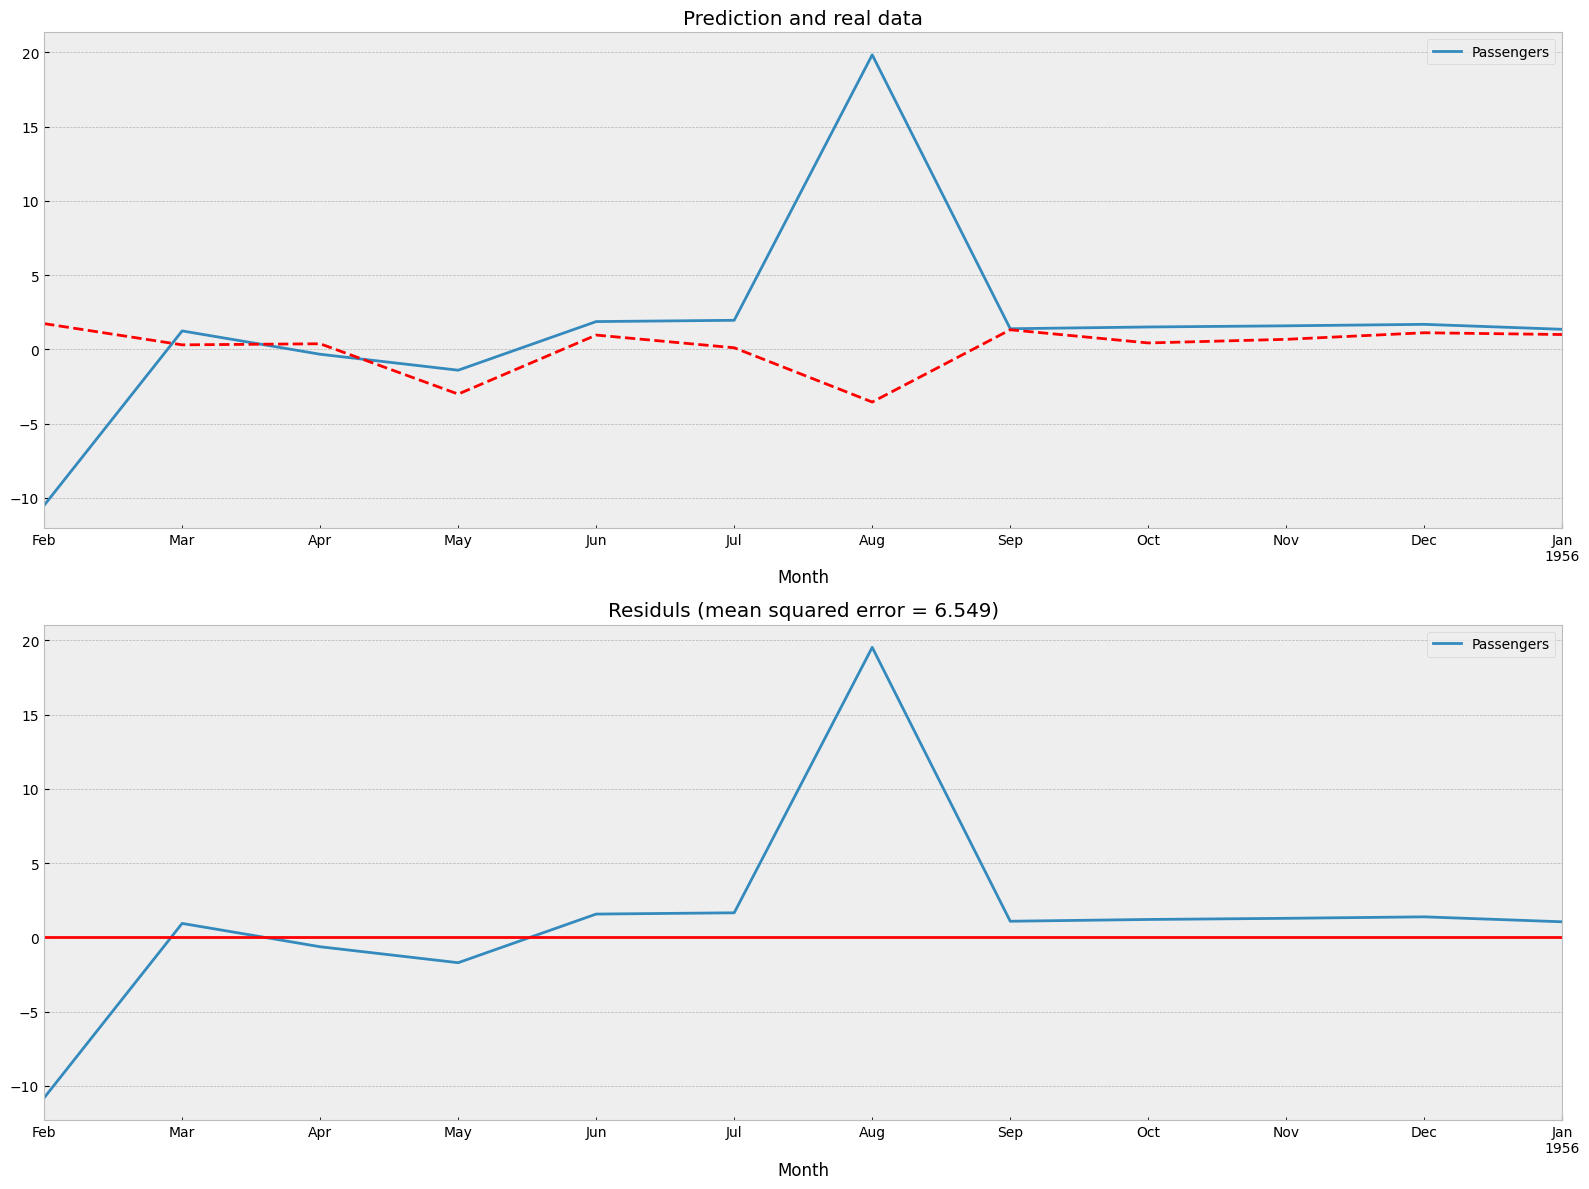

In [101]:
def trailModel(ts_model, timeSeries, figsize=(16, 12), style='bmh'):
    predictions = ts_model.predict(start = timeSeries.index[0], end = timeSeries.index[-1])
    residual = timeSeries - predictions[1]
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (2, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        rs_ax = plt.subplot2grid(layout, (1, 0))

        timeSeries.plot(ax = ts_ax)
        predictions.plot(ax = ts_ax, color = 'r', linestyle = '--')
        #ts_ax.plot(predictions.index, predictions, color = 'r', linestyle = '--')
        
        ts_ax.set_title('Prediction and real data')
      
        residual.plot(ax = rs_ax) 
        rs_ax.axhline(0, color = 'r')
        rs_ax.set_title(f'Residuls (mean squared error = { np.round(np.sqrt(np.mean(residual ** 2)), 3) })')
        plt.tight_layout()
    

trailModel(model_fit, timeSeries= test_data)

# 7. Undo transformation  <a id='undo_transformation'></a>
[Back to top](#table_of_contents)

In [97]:
def rowFunctinoUndo(row, ave_m):
    print([row, row.index])
    indexMonth = row.index.month
    return row * ave_m[indexMonth]

def undoTransformation(predictions, original_series, ave_m, figsize=(10, 5), style='bmh'):
    # add seasonality 
    equalSize_month_avg =  original_series.index.map(lambda d: month_avgs.loc[d.month][0])
    equalSize_month_avg =  transformed_airpassenger.index.map(lambda d: month_avgs.loc[d.month][0])
    
    indexed_equalSize_month_avg = pd.DataFrame( {str(transformed_airpassenger.columns[0]): equalSize_month_avg}, index= transformed_airpassenger.index)

    transformed_airpassenger = transformed_airpassenger / indexed_equalSize_month_avg

    print(predictions)
    predictions = predictions 
    print(predictions)


    # add first difference
    predictions = predictions.diffinv()
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        plt.plot(predictions.index, predictions, color = 'red', label = 'prediction', linestyle = '--')
        plt.plot(original_series.index, original_series, color = 'black', label = 'prediction')

        plt.tight_layout()


undoTransformation(model_fit.predict(start = test_data.index[0], end = test_data.index[-1]), airpassenger[train_end + timedelta(days= 1): test_end], month_avgs)
        


1955-02-01   -2.716194
1955-03-01    2.612803
1955-04-01    2.621144
1955-05-01   -7.242798
1955-06-01    4.836145
1955-07-01   -3.710631
1955-08-01    0.705831
1955-09-01   -1.865723
1955-10-01    3.160634
1955-11-01   -2.763712
1955-12-01    0.602279
1956-01-01    0.950790
Freq: MS, Name: predicted_mean, dtype: float64


KeyError: 2